In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread("data/cat.bmp")[:,:,::-1]
w = img.shape[0]
h = img.shape[1]

In [48]:
def plot_side_by_side(img1, img2):
    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title("Image 1")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.title("Image 2")

## Original Image

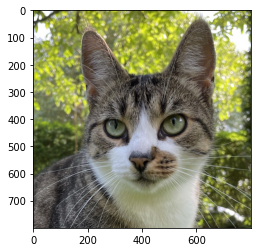

In [49]:
plt.imshow(img)

## RGB to YCbCr conversion

Text(0.5, 1.0, 'Image 2')

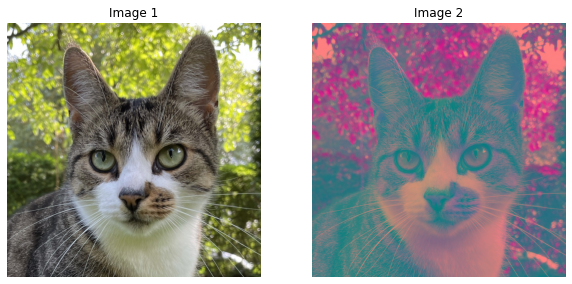

In [50]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float32)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

ycbcr = rgb2ycbcr(img)

# vielleicht hier noch die einzelnen farbkanäle von ycbcr getrennt zeigen?
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(img)
#plt.imsave("data/cat_rgb.png", img)
plt.axis('off')
plt.title("Image 1")

fig.add_subplot(rows, columns, 2)
plt.imshow(ycbcr)
#plt.imsave("data/cat_ycbcr.png", ycbcr)
plt.axis('off')
plt.title("Image 2")


## Downsampling/Chroma subsampling (4:2:0)

Text(0.5, 1.0, 'Chroma subsampled (4:2:0)\nwith luma')

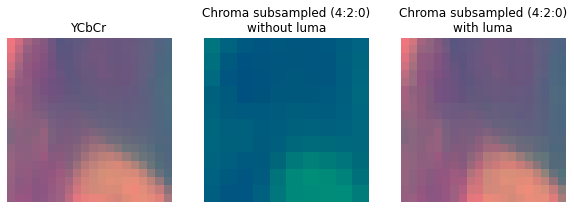

In [51]:
block_size = 2
def chroma_subsample(ycbcr):
    a = np.array(ycbcr)
    for y in range(0,h,block_size):
        for x in range(0,w,block_size):
            block = a[x:x+block_size,y:y+block_size,1:]
            a[x:x+block_size,y:y+block_size,1:] = np.full((block_size,block_size,2), block[0,0])
    return np.uint8(a)

css = chroma_subsample(ycbcr)

ycbcr_no_luma = np.copy(ycbcr)
ycbcr_no_luma[:,:,0] = 0 # set luma channel to 0 for better visualization

(x,y) = (0, 0)
size = 20 

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(ycbcr[x:x+size,y:y+size,:])
#plt.imsave("data/ycbcr_no_subsampling.png", ycbcr[x:x+size,y:y+size,:])
plt.axis('off')
plt.title("YCbCr")

fig.add_subplot(rows, columns, 2)
plt.imshow(chroma_subsample(ycbcr_no_luma)[x:x+size,y:y+size,:])
#plt.imsave("data/subsampling_no_luma.png", chroma_subsample(ycbcr_no_luma)[x:x+size,y:y+size,:])
plt.axis('off')
plt.title("Chroma subsampled (4:2:0)\nwithout luma")

fig.add_subplot(rows, columns, 3)
plt.imshow(chroma_subsample(ycbcr)[x:x+size,y:y+size,:])
#plt.imsave("data/ycbcr_no_subsampling.png", chroma_subsample(ycbcr)[x:x+size,y:y+size,:])
plt.axis('off')
plt.title("Chroma subsampled (4:2:0)\nwith luma")

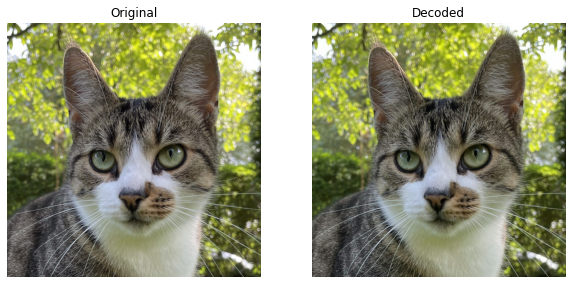

In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import ceil
from scipy.fftpack import dct, idct

css_block_size = 2
dct_block_size = 8
Q = 100

QTY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

S = 5000/Q if Q < 50 else 200 - 2*Q
QTY = np.clip(np.floor((S * QTY + 50) / 100), 1, None)
QTC = np.clip(np.floor((S * QTC + 50) / 100), 1, None)


def rgb2ycbcr(img):
    coeffs = np.array([[.299, .587, .114], [-.168736, -.331264, .5], [.5, -.418688, -.081312]])
    ycbcr = img.dot(coeffs.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(img):
    coeffs = np.array([[1, 0, 1.402], [1, -.344136, -.714136], [1, 1.772, 0]])
    rgb = img.astype(np.float32)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(coeffs.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

def chroma_subsample(ycbcr):
    w, h = ycbcr.shape[:2]
    block_sz = css_block_size
    a = np.array(ycbcr)
    for y in range(0, h, block_sz):
        for x in range(0, w, block_sz):
            block = a[x:x + block_sz, y:y + block_sz, 1:]
            a[x:x + block_sz, y:y + block_sz, 1:] = np.full((block_sz, block_sz,2), block[0,0])
    return np.uint8(a)

img = cv2.imread("data/cat.bmp")[:,:,::-1]
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original")

(w, h) = img.shape[:2]

# add padding to the image if it's size is not a multiple of 8
(padded_w, padded_h) = (ceil(w / dct_block_size) * dct_block_size, ceil(h / dct_block_size) * dct_block_size)
img = np.pad(img, ((0, padded_h - h), (0, padded_w - w), (0, 0)), mode="mean")

# convert color space to YCbCr
img = rgb2ycbcr(img)

# apply chroma subsampling (4:2:0)
img = chroma_subsample(img)

# encode dct + quantization
img_dct = img.astype(np.int16)
for y in range(0, padded_h, dct_block_size):
    for x in range(0, padded_w, dct_block_size):
        for z in range(3):
            block = img_dct[x:x + dct_block_size, y:y + dct_block_size, z] - 128
            block = cv2.dct(block.astype(np.float32))
            block /= QTY if z == 0 else QTC
            img_dct[x:x + dct_block_size, y:y + dct_block_size, z] = block

# decode dct + quantization
for y in range(0, padded_h, dct_block_size):
    for x in range(0, padded_w, dct_block_size):
        for z in range(3):
            block = img_dct[x:x + dct_block_size, y:y + dct_block_size, z]
            block = block * (QTY if z == 0 else QTC)
            block = cv2.idct(block)
            block = np.clip(block + 128, 0, 255).astype(np.uint8)
            img[x:x + dct_block_size, y:y + dct_block_size, z] = block

# convert back to rgb
img = ycbcr2rgb(img)

fig.add_subplot(rows, columns, 2)
plt.imshow(img)
plt.axis('off')
plt.title("Decoded")

plt.imsave("data/out.bmp", img)